# Analysis of Peptide Contact Map

In this notebook, we analyze an all-atom MD simulation of a peptide system in explicit solvent using `MDAnalysis` python pachage. We focus on extracting key structural and dynamic properties relevant for aggregation behavior and peptide phase behavior:

- Contact Map

Trajectory: 50 ns with 500 ps timestep
System: 100 short disordered peptides in water and ion solution (water and ions are not present in the .xtc file)

In [1]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import rms
import seaborn as sns
sns.set(style="white")

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts import helpers as h

In [3]:
%loacm_ext autoreload
%autoreload 2

UsageError: Line magic function `%loacm_ext` not found.


### Loading the trajectory

In [4]:
u, times, chains = h.init_trj('../data/initial.pdb','../data/pbc.md.xtc')

Trjectory of 101 frames of 50000.0 ps with a timestep of 500.0 ps
Box size: 57.0 57.0 116.910400390625 $\AA$
There is 9400 total atoms ( 100 chains each of 94 atoms )
Unique residues  ['ACE' 'GLN' 'GLY' 'NME' 'TYR']


In [5]:
nchains = len(chains)
nframes = len(times)

### Calculating contact matrix
We will use MDAnalysis to compute contact matrix between heavy atoms of our peptide

In [6]:
from MDAnalysis.lib import distances

In [7]:
chains_hh = [chain.select_atoms('not name H*') for chain in chains]
# chains_hh = [chain.select_atoms('name CA') for chain in chains]
nres = len(chains_hh[0])
print(f'There is {nres} heavy atoms in this peptide, unique once are : {np.unique(chains_hh[0].atoms.names)}')

There is 53 heavy atoms in this peptide, unique once are : ['C' 'CA' 'CB' 'CD' 'CD1' 'CD2' 'CE1' 'CE2' 'CG' 'CZ' 'N' 'NE2' 'O' 'OE1'
 'OH']


In [8]:
cutoff = 4.5 # Angstrom
work_frames = u.trajectory[20::10]
normalization = len(work_frames) * nchains

cm_intra = np.zeros((nres,nres))
cm_inter = np.zeros((nres,nres))

for ifr,frame in enumerate(work_frames):
    for i,chaini in enumerate(chains_hh):
        # result = np.zeros((nres,nres))
        d = distances.distance_array(chaini.positions,chaini.positions,box=u.dimensions)#,result=result)
        cm_intra += d < cutoff
        for j,chainj in enumerate(chains_hh[i+1:]):
            # result = np.zeros((nres,nres))
            d = distances.distance_array(chaini.positions,chainj.positions,box=u.dimensions)#,result=result)
            cm_inter += d < cutoff
            cm_inter += (d < cutoff).T
for i in range(nres):   
    cm_intra[i,i] = 0
# normalizing 
cm_intra_sc = cm_intra/normalization
cm_inter_sc = cm_inter/normalization# * (nchains-1))#/2)
cm_total_sc = cm_intra_sc + cm_inter_sc

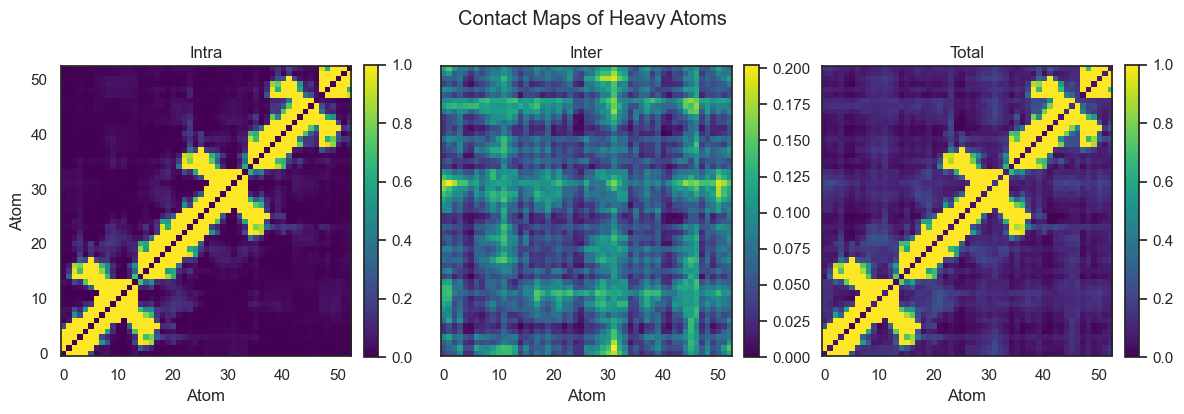

In [34]:
labels = ['Intra', 'Inter', 'Total'] 
fig,axs = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
cm_intra_im = axs[0].imshow(cm_intra_sc,origin='lower',cmap='viridis', vmin=0,vmax=1)
cm_inter_im = axs[1].imshow(cm_inter_sc,origin='lower',cmap='viridis', vmin=0)#vmax=1)
cm_tot_im = axs[2].imshow(cm_total_sc,origin='lower',cmap='viridis', vmin=0,vmax=1)

plt.colorbar(cm_intra_im,fraction=0.046, pad=0.04)
plt.colorbar(cm_inter_im,fraction=0.046, pad=0.04)
plt.colorbar(cm_tot_im,fraction=0.046, pad=0.04)

axs[0].set_ylabel('Atom')
[ax.set_xlabel('Atom') for ax in axs]
[ax.set_title(labels[i]) for i,ax in enumerate(axs)]

plt.suptitle('Contact Maps of Heavy Atoms')
plt.tight_layout()
h.save_png(fig,'../figures/contacts.png')